# Download library

In [1]:
!pip install transformers==4.28.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 27.8 MB/s eta 0:00:00


In [2]:
!pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 3.9 MB/s eta 0:00:00


In [3]:
!pip install git+https://github.com/huggingface/accelerate

  Cloning https://github.com/huggingface/accelerate to /tmp/pip-req-build-r1v221b5
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/accelerate /tmp/pip-req-build-r1v221b5
  Resolved https://github.com/huggingface/accelerate to commit d5894ab4992878c191ed4c9fdb53b35ad2c0e628
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for accelerate: filename=accelerate-0.22.0.dev0-py3-none-any.whl size=247982 sha256=ba26c593138a1850fb08c3e47a44985217cef3c028c6db5b078725bd747c03bc
  Stored in directory: /tmp/pip-ephem-wheel-cache-p9fmpv8m/wheels/f6/c7/9d/1b8a5ca8353d9307733bc719107acb67acdc95063bba749f26
Successfully built accelerate
  Attempting uninstall: accelerate
    Found existing installation: accelerate 0.21.0
    Uninstalling accelerate-0.21.0:
      Successfully uninstalled accelerate-0.21.0


In [4]:
# !pip install huggingface_hub

# Load data and pre-processing

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import os

os.environ['CURL_CA_BUNDLE'] = ''

In [7]:
import transformers
from transformers import AdamW, get_linear_schedule_with_warmup
from transformers import BertModel, BertTokenizer
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from tqdm.notebook import tqdm

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [33]:
df=pd.read_csv("/content/drive/MyDrive/yahoo_QA/train.csv",names=['class', 'title', 'content', 'answer'])


In [34]:
categories = {1: 'Society & Culture', 2: 'Science & Mathematics', 3: 'Health', 4: 'Education & Reference',
              5: 'Computers & Internet', 6: 'Sports', 7: 'Business & Finance', 8: 'Entertainment & Music',
              9: 'Family & Relationships', 10: 'Politics & Government'}

In [35]:
labels=['Society & Culture', 'Science & Mathematics', 'Health', 'Education & Reference',
        'Computers & Internet', 'Sports', 'Business & Finance', 'Entertainment & Music',
        'Family & Relationships', 'Politics & Government']

In [36]:
df['label'] = df['class'].map(categories)

In [37]:
df = df.drop('class', axis=1)

In [38]:
label_dict = dict(zip(labels, range(0,len(labels))))
df['index']=df['label'].apply(labels.index)

In [39]:
df.groupby(['label']).size()

label
Business & Finance        140000
Computers & Internet      140000
Education & Reference     140000
Entertainment & Music     140000
Family & Relationships    140000
Health                    140000
Politics & Government     140000
Science & Mathematics     140000
Society & Culture         140000
Sports                    140000
dtype: int64

In [15]:
import random
#1: 'Society & Culture', 2: 'Science & Mathematics', 3: 'Health', 4: 'Education & Reference', 5: 'Computers & Internet'
# Return a list of indices
cul_idx=random.sample(list(df.query('label=="Society & Culture"').index), 605)
sci_idx=random.sample(list(df.query('label=="Science & Mathematics"').index),197)
health_idx=random.sample(list(df.query('label=="Health"').index),346)
edu_idx=random.sample(list(df.query('label=="Education & Reference"').index),183)
comp_idx=random.sample(list(df.query('label=="Computers & Internet"').index),944)

# Use indices to select data
df= df.loc[cul_idx + sci_idx + health_idx+ edu_idx + comp_idx]
index_list=cul_idx + sci_idx + health_idx+ edu_idx + comp_idx

In [16]:
from sklearn.utils import shuffle
df = shuffle(df)

# Model

In [17]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'huggingface.co'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'huggingface.co'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'huggingface.co'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'huggingface.co'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'huggingface.co'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056

/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'huggingface.co'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'huggingface.co'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


In [18]:
class MainDataset(Dataset):

    def __init__(self, text, targets, tokenizer, max_len):
        self.text = text
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, item):
        text = str(self.text[item])
        target = self.targets[item]

        encoding = self.tokenizer.encode_plus(text,
                                              add_special_tokens=True,
                                              max_length=self.max_len,
                                              return_token_type_ids=False,
                                              pad_to_max_length=True,
                                              return_attention_mask=True,
                                              return_tensors='pt',
                                              truncation = True
                                             )
        return {'text': text,
                'input_ids': encoding['input_ids'].flatten(),
                'attention_mask': encoding['attention_mask'].flatten(),
                'targets': torch.tensor(target, dtype=torch.long)}

In [19]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = MainDataset(
    text=df['title'].to_numpy(),
    targets=df['index'].to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size
  )

In [20]:
class Classifier(nn.Module):

  def __init__(self, n_classes):
    super(Classifier, self).__init__()
    self.bert = BertModel.from_pretrained('bert-base-cased')
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

  def forward(self, input_ids, attention_mask,return_dict=False):
    _, pooled_output = self.bert(input_ids=input_ids,attention_mask=attention_mask, return_dict=False)
    output = self.drop(pooled_output)
    return self.out(output)

In [21]:
import torch
torch.cuda.empty_cache()

In [22]:
class Train_Model:

  def __init__(self, model, loss_fn, optimizer, device, scheduler, n_examples):
    self.model=model
    self.loss_fn=loss_fn
    self.optimizer=optimizer
    self.device=device
    self.scheduler=scheduler
    self.n_examples=n_examples

  def train_epoch(self, train_data_loader):
    model = self.model.train()

    losses = []
    correct_predictions = 0

    for d in tqdm(train_data_loader):
      input_ids = d["input_ids"].to(self.device)
      attention_mask = d["attention_mask"].to(self.device)
      targets = d["targets"].to(self.device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask, return_dict=False
      )

      _, preds = torch.max(outputs, dim=1)
      loss = self.loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

      loss.backward()
      nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
      self.optimizer.step()
      self.scheduler.step()
      self.optimizer.zero_grad()

    return correct_predictions.double() / self.n_examples, np.mean(losses)

  def eval_model(self, val_data_loader):
      model = self.model.eval()

      losses = []
      correct_predictions = 0

      with torch.no_grad():
        for d in tqdm(val_data_loader):
          input_ids = d["input_ids"].to(self.device)
          attention_mask = d["attention_mask"].to(self.device)
          targets = d["targets"].to(self.device)

          outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,return_dict=False
          )
          _, preds = torch.max(outputs, dim=1)

          loss = self.loss_fn(outputs, targets)

          correct_predictions += torch.sum(preds == targets)
          losses.append(loss.item())

      return correct_predictions.double() / self.n_examples, np.mean(losses)

  def get_predictions(self, test_data_loader):
      model = self.model.eval()

      texts = []
      predictions = []
      prediction_probs = []
      real_values = []

      with torch.no_grad():
        for d in test_data_loader:

          text = d["text"]
          input_ids = d["input_ids"].to(self.device)
          attention_mask = d["attention_mask"].to(self.device)
          targets = d["targets"].to(self.device)

          outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
          )
          _, preds = torch.max(outputs, dim=1)

          probs = F.softmax(outputs, dim=1)

          texts.extend(text)
          predictions.extend(preds)
          prediction_probs.extend(probs)
          real_values.extend(targets)

      predictions = torch.stack(predictions).cpu()
      prediction_probs = torch.stack(prediction_probs).cpu()
      real_values = torch.stack(real_values).cpu()
      return texts, predictions, prediction_probs, real_values

# Train (r ratio)


In [23]:
import random
#1: 'Society & Culture', 2: 'Science & Mathematics', 3: 'Health', 4: 'Education & Reference', 5: 'Computers & Internet'
# Return a list of indices
cul_idx=random.sample(list(df.query('label=="Society & Culture"').index), 10)
sci_idx=random.sample(list(df.query('label=="Science & Mathematics"').index),10)
health_idx=random.sample(list(df.query('label=="Health"').index),10)
edu_idx=random.sample(list(df.query('label=="Education & Reference"').index),10)
comp_idx=random.sample(list(df.query('label=="Computers & Internet"').index),10)

# Use indices to select data
train= df.loc[cul_idx + sci_idx + health_idx+ edu_idx + comp_idx]
index_list=cul_idx + sci_idx + health_idx+ edu_idx + comp_idx

In [24]:
test=df.drop(index=(index_list))
valid, test = train_test_split(test, test_size=0.8)

In [25]:
train_data_loader = create_data_loader(train, tokenizer, max_len=128, batch_size=16)
val_data_loader = create_data_loader(valid, tokenizer, max_len=128, batch_size=16)
test_data_loader = create_data_loader(test, tokenizer, max_len=128, batch_size=16)

In [26]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [27]:
# define parameters
EPOCHS = 20

model = Classifier(len(labels))
model = model.to(device)

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps)

loss_fn = nn.CrossEntropyLoss().to(device)

# define researcher's model

R_model_train=Train_Model(model, loss_fn, optimizer, device, scheduler, len(train))

/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'huggingface.co'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'huggingface.co'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'cdn-lfs.huggingface.co'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a 

In [28]:
history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = R_model_train.train_epoch(train_data_loader)

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = R_model_train.eval_model(val_data_loader)

  print(f'Val loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Train loss 2.2985721826553345 accuracy 0.08


  0%|          | 0/28 [00:00<?, ?it/s]

Val loss 2.001366687672479 accuracy 2.08

Epoch 2/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

Train loss 2.03335839509964 accuracy 0.3


  0%|          | 0/28 [00:00<?, ?it/s]

Val loss 1.7823905178478785 accuracy 2.16

Epoch 3/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

Train loss 1.713137447834015 accuracy 0.42


  0%|          | 0/28 [00:00<?, ?it/s]

Val loss 1.6006865288530077 accuracy 4.72

Epoch 4/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

Train loss 1.5421250462532043 accuracy 0.44


  0%|          | 0/28 [00:00<?, ?it/s]

Val loss 1.4829297832080297 accuracy 4.34

Epoch 5/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

Train loss 1.366665095090866 accuracy 0.42


  0%|          | 0/28 [00:00<?, ?it/s]

Val loss 1.3783278592995234 accuracy 5.44

Epoch 6/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

Train loss 1.0531794279813766 accuracy 0.68


  0%|          | 0/28 [00:00<?, ?it/s]

Val loss 1.2869369047028678 accuracy 5.62

Epoch 7/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

Train loss 0.8540327250957489 accuracy 0.8200000000000001


  0%|          | 0/28 [00:00<?, ?it/s]

Val loss 1.184646685208593 accuracy 5.94

Epoch 8/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

Train loss 0.5986641496419907 accuracy 0.98


  0%|          | 0/28 [00:00<?, ?it/s]

Val loss 1.0648816994258337 accuracy 6.28

Epoch 9/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

Train loss 0.4376966133713722 accuracy 1.0


  0%|          | 0/28 [00:00<?, ?it/s]

Val loss 1.0873278847762518 accuracy 5.48

Epoch 10/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

Train loss 0.26631972938776016 accuracy 1.0


  0%|          | 0/28 [00:00<?, ?it/s]

Val loss 1.030634039214679 accuracy 5.7

Epoch 11/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

Train loss 0.1891314499080181 accuracy 1.0


  0%|          | 0/28 [00:00<?, ?it/s]

Val loss 1.0567994649921144 accuracy 5.58

Epoch 12/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

Train loss 0.12676040176302195 accuracy 1.0


  0%|          | 0/28 [00:00<?, ?it/s]

Val loss 1.0290870240756445 accuracy 5.8

Epoch 13/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

Train loss 0.1029505655169487 accuracy 1.0


  0%|          | 0/28 [00:00<?, ?it/s]

Val loss 1.0593369475432806 accuracy 5.7

Epoch 14/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

Train loss 0.06353909382596612 accuracy 1.0


  0%|          | 0/28 [00:00<?, ?it/s]

Val loss 1.0598550172788757 accuracy 5.8

Epoch 15/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

Train loss 0.052663069451227784 accuracy 1.0


  0%|          | 0/28 [00:00<?, ?it/s]

Val loss 1.0894360201699393 accuracy 5.74

Epoch 16/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

Train loss 0.038266221061348915 accuracy 1.0


  0%|          | 0/28 [00:00<?, ?it/s]

Val loss 1.1151468477078847 accuracy 5.74

Epoch 17/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

Train loss 0.038240917259827256 accuracy 1.0


  0%|          | 0/28 [00:00<?, ?it/s]

Val loss 1.1497585049697332 accuracy 5.64

Epoch 18/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

Train loss 0.03045753249898553 accuracy 1.0


  0%|          | 0/28 [00:00<?, ?it/s]

Val loss 1.1732079961470194 accuracy 5.6000000000000005

Epoch 19/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

Train loss 0.02869135676883161 accuracy 1.0


  0%|          | 0/28 [00:00<?, ?it/s]

Val loss 1.180750378540584 accuracy 5.58

Epoch 20/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

Train loss 0.026621463242918253 accuracy 1.0


  0%|          | 0/28 [00:00<?, ?it/s]

Val loss 1.1816654290471758 accuracy 5.6000000000000005



In [29]:
y_texts, y_pred, y_pred_probs, y_test = R_model_train.get_predictions(test_data_loader)

In [30]:
from sklearn.metrics import balanced_accuracy_score

acc=balanced_accuracy_score(y_test, y_pred)
acc

0.5204706402868492

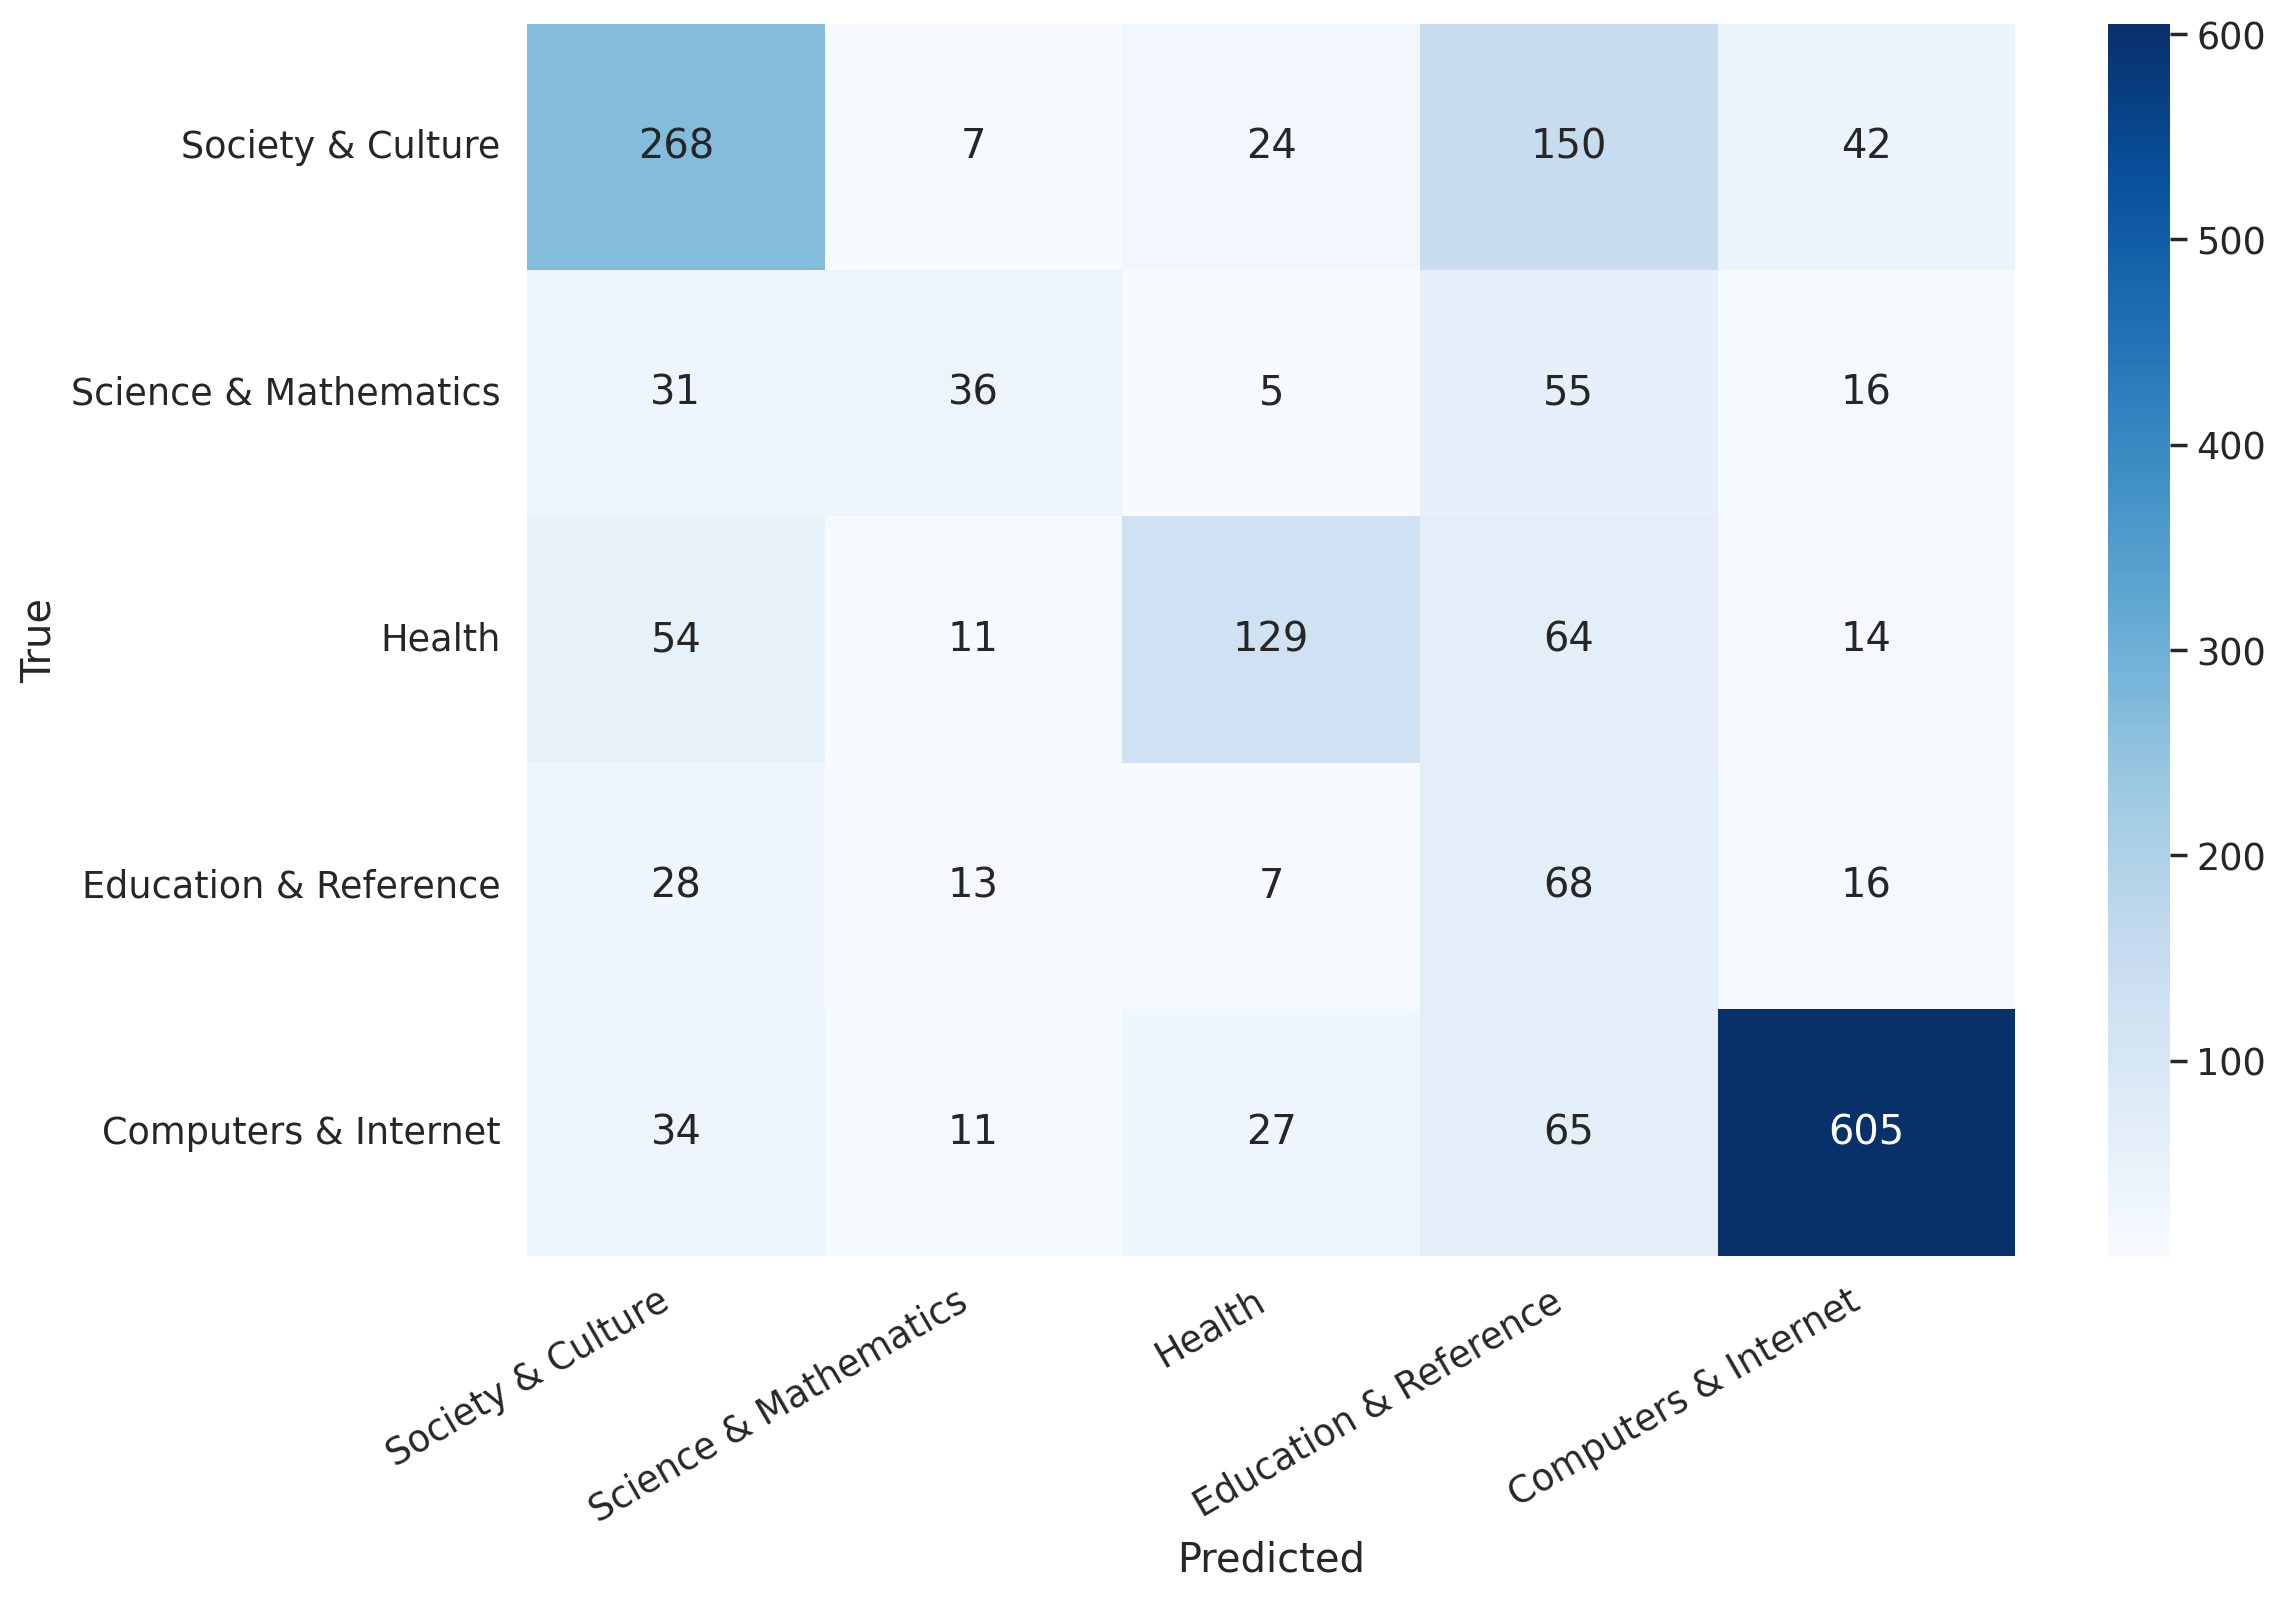

In [31]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True')
  plt.xlabel('Predicted');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=labels[0:5], columns=labels[0:5])
show_confusion_matrix(df_cm)

In [32]:
print(classification_report(y_test, y_pred, target_names=labels[0:5]))

                       precision    recall  f1-score   support

    Society & Culture       0.65      0.55      0.59       491
Science & Mathematics       0.46      0.25      0.33       143
               Health       0.67      0.47      0.56       272
Education & Reference       0.17      0.52      0.25       132
 Computers & Internet       0.87      0.82      0.84       742

             accuracy                           0.62      1780
            macro avg       0.56      0.52      0.51      1780
         weighted avg       0.69      0.62      0.64      1780



# Train (p ratio)


In [40]:
import random
#1: 'Society & Culture', 2: 'Science & Mathematics', 3: 'Health', 4: 'Education & Reference', 5: 'Computers & Internet'
# Return a list of indices
cul_idx=random.sample(list(df.query('label=="Society & Culture"').index), 555)
sci_idx=random.sample(list(df.query('label=="Science & Mathematics"').index),131)
health_idx=random.sample(list(df.query('label=="Health"').index),535)
edu_idx=random.sample(list(df.query('label=="Education & Reference"').index),240)
comp_idx=random.sample(list(df.query('label=="Computers & Internet"').index),359)

# Use indices to select data
df2= df.loc[cul_idx + sci_idx + health_idx+ edu_idx + comp_idx]
index_list2=cul_idx + sci_idx + health_idx+ edu_idx + comp_idx

from sklearn.utils import shuffle
df2= shuffle(df2)

In [41]:
# Return a list of indices
cul_idx=random.sample(list(df2.query('label=="Society & Culture"').index), 10)
sci_idx=random.sample(list(df2.query('label=="Science & Mathematics"').index),10)
health_idx=random.sample(list(df2.query('label=="Health"').index),10)
edu_idx=random.sample(list(df2.query('label=="Education & Reference"').index),10)
comp_idx=random.sample(list(df2.query('label=="Computers & Internet"').index),10)

# Use indices to select data
train= df2.loc[cul_idx + sci_idx + health_idx+ edu_idx + comp_idx]
index_list=cul_idx + sci_idx + health_idx+ edu_idx + comp_idx

In [42]:
test=df2.drop(index=(index_list))
valid, test = train_test_split(test, test_size=0.8)

In [43]:
train_data_loader = create_data_loader(train, tokenizer, max_len=128, batch_size=16)
val_data_loader = create_data_loader(valid, tokenizer, max_len=128, batch_size=16)
test_data_loader = create_data_loader(test, tokenizer, max_len=128, batch_size=16)

In [44]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [45]:
# define parameters
EPOCHS = 20

model = Classifier(len(labels))
model = model.to(device)

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps)

loss_fn = nn.CrossEntropyLoss().to(device)

# define researcher's model

R_model_train=Train_Model(model, loss_fn, optimizer, device, scheduler, len(train))

/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'huggingface.co'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkp

In [46]:
history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = R_model_train.train_epoch(train_data_loader)

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = R_model_train.eval_model(val_data_loader)

  print(f'Val loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Train loss 2.5297866463661194 accuracy 0.04


  0%|          | 0/23 [00:00<?, ?it/s]

Val loss 2.15928780514261 accuracy 2.2

Epoch 2/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

Train loss 2.169539451599121 accuracy 0.16


  0%|          | 0/23 [00:00<?, ?it/s]

Val loss 1.880848272987034 accuracy 2.2

Epoch 3/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

Train loss 1.7917692959308624 accuracy 0.34


  0%|          | 0/23 [00:00<?, ?it/s]

Val loss 1.724572523780491 accuracy 2.96

Epoch 4/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

Train loss 1.4863946288824081 accuracy 0.4


  0%|          | 0/23 [00:00<?, ?it/s]

Val loss 1.6184895194095115 accuracy 2.82

Epoch 5/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

Train loss 1.3720752596855164 accuracy 0.64


  0%|          | 0/23 [00:00<?, ?it/s]

Val loss 1.8843893797501274 accuracy 1.52

Epoch 6/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

Train loss 1.2676680386066437 accuracy 0.54


  0%|          | 0/23 [00:00<?, ?it/s]

Val loss 1.404396855312845 accuracy 3.7800000000000002

Epoch 7/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

Train loss 1.0191940069198608 accuracy 0.88


  0%|          | 0/23 [00:00<?, ?it/s]

Val loss 1.3101268488427866 accuracy 4.2

Epoch 8/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

Train loss 0.6472338438034058 accuracy 0.96


  0%|          | 0/23 [00:00<?, ?it/s]

Val loss 1.3182088654974233 accuracy 3.24

Epoch 9/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

Train loss 0.48252179473638535 accuracy 0.96


  0%|          | 0/23 [00:00<?, ?it/s]

Val loss 1.201024724089581 accuracy 4.12

Epoch 10/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

Train loss 0.33054765686392784 accuracy 1.0


  0%|          | 0/23 [00:00<?, ?it/s]

Val loss 1.1372329437214395 accuracy 4.16

Epoch 11/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

Train loss 0.2132348995655775 accuracy 1.0


  0%|          | 0/23 [00:00<?, ?it/s]

Val loss 1.1480197569598323 accuracy 4.18

Epoch 12/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

Train loss 0.149522022344172 accuracy 1.0


  0%|          | 0/23 [00:00<?, ?it/s]

Val loss 1.1257688817770586 accuracy 4.3

Epoch 13/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

Train loss 0.10915136802941561 accuracy 1.0


  0%|          | 0/23 [00:00<?, ?it/s]

Val loss 1.1125983621763147 accuracy 4.42

Epoch 14/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

Train loss 0.08328035287559032 accuracy 1.0


  0%|          | 0/23 [00:00<?, ?it/s]

Val loss 1.1192250096279641 accuracy 4.5

Epoch 15/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

Train loss 0.06613719742745161 accuracy 1.0


  0%|          | 0/23 [00:00<?, ?it/s]

Val loss 1.1789749808933423 accuracy 4.36

Epoch 16/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

Train loss 0.05102615524083376 accuracy 1.0


  0%|          | 0/23 [00:00<?, ?it/s]

Val loss 1.2024347989455513 accuracy 4.36

Epoch 17/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

Train loss 0.040913930628448725 accuracy 1.0


  0%|          | 0/23 [00:00<?, ?it/s]

Val loss 1.2181551197300786 accuracy 4.36

Epoch 18/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

Train loss 0.03579809982329607 accuracy 1.0


  0%|          | 0/23 [00:00<?, ?it/s]

Val loss 1.2188155366026836 accuracy 4.4

Epoch 19/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

Train loss 0.036889524199068546 accuracy 1.0


  0%|          | 0/23 [00:00<?, ?it/s]

Val loss 1.2151832036350085 accuracy 4.4

Epoch 20/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

Train loss 0.03425418818369508 accuracy 1.0


  0%|          | 0/23 [00:00<?, ?it/s]

Val loss 1.2118880619173464 accuracy 4.38



In [47]:
y_texts, y_pred, y_pred_probs, y_test = R_model_train.get_predictions(test_data_loader)

In [48]:
from sklearn.metrics import balanced_accuracy_score

acc=balanced_accuracy_score(y_test, y_pred)
acc

0.575862538932699

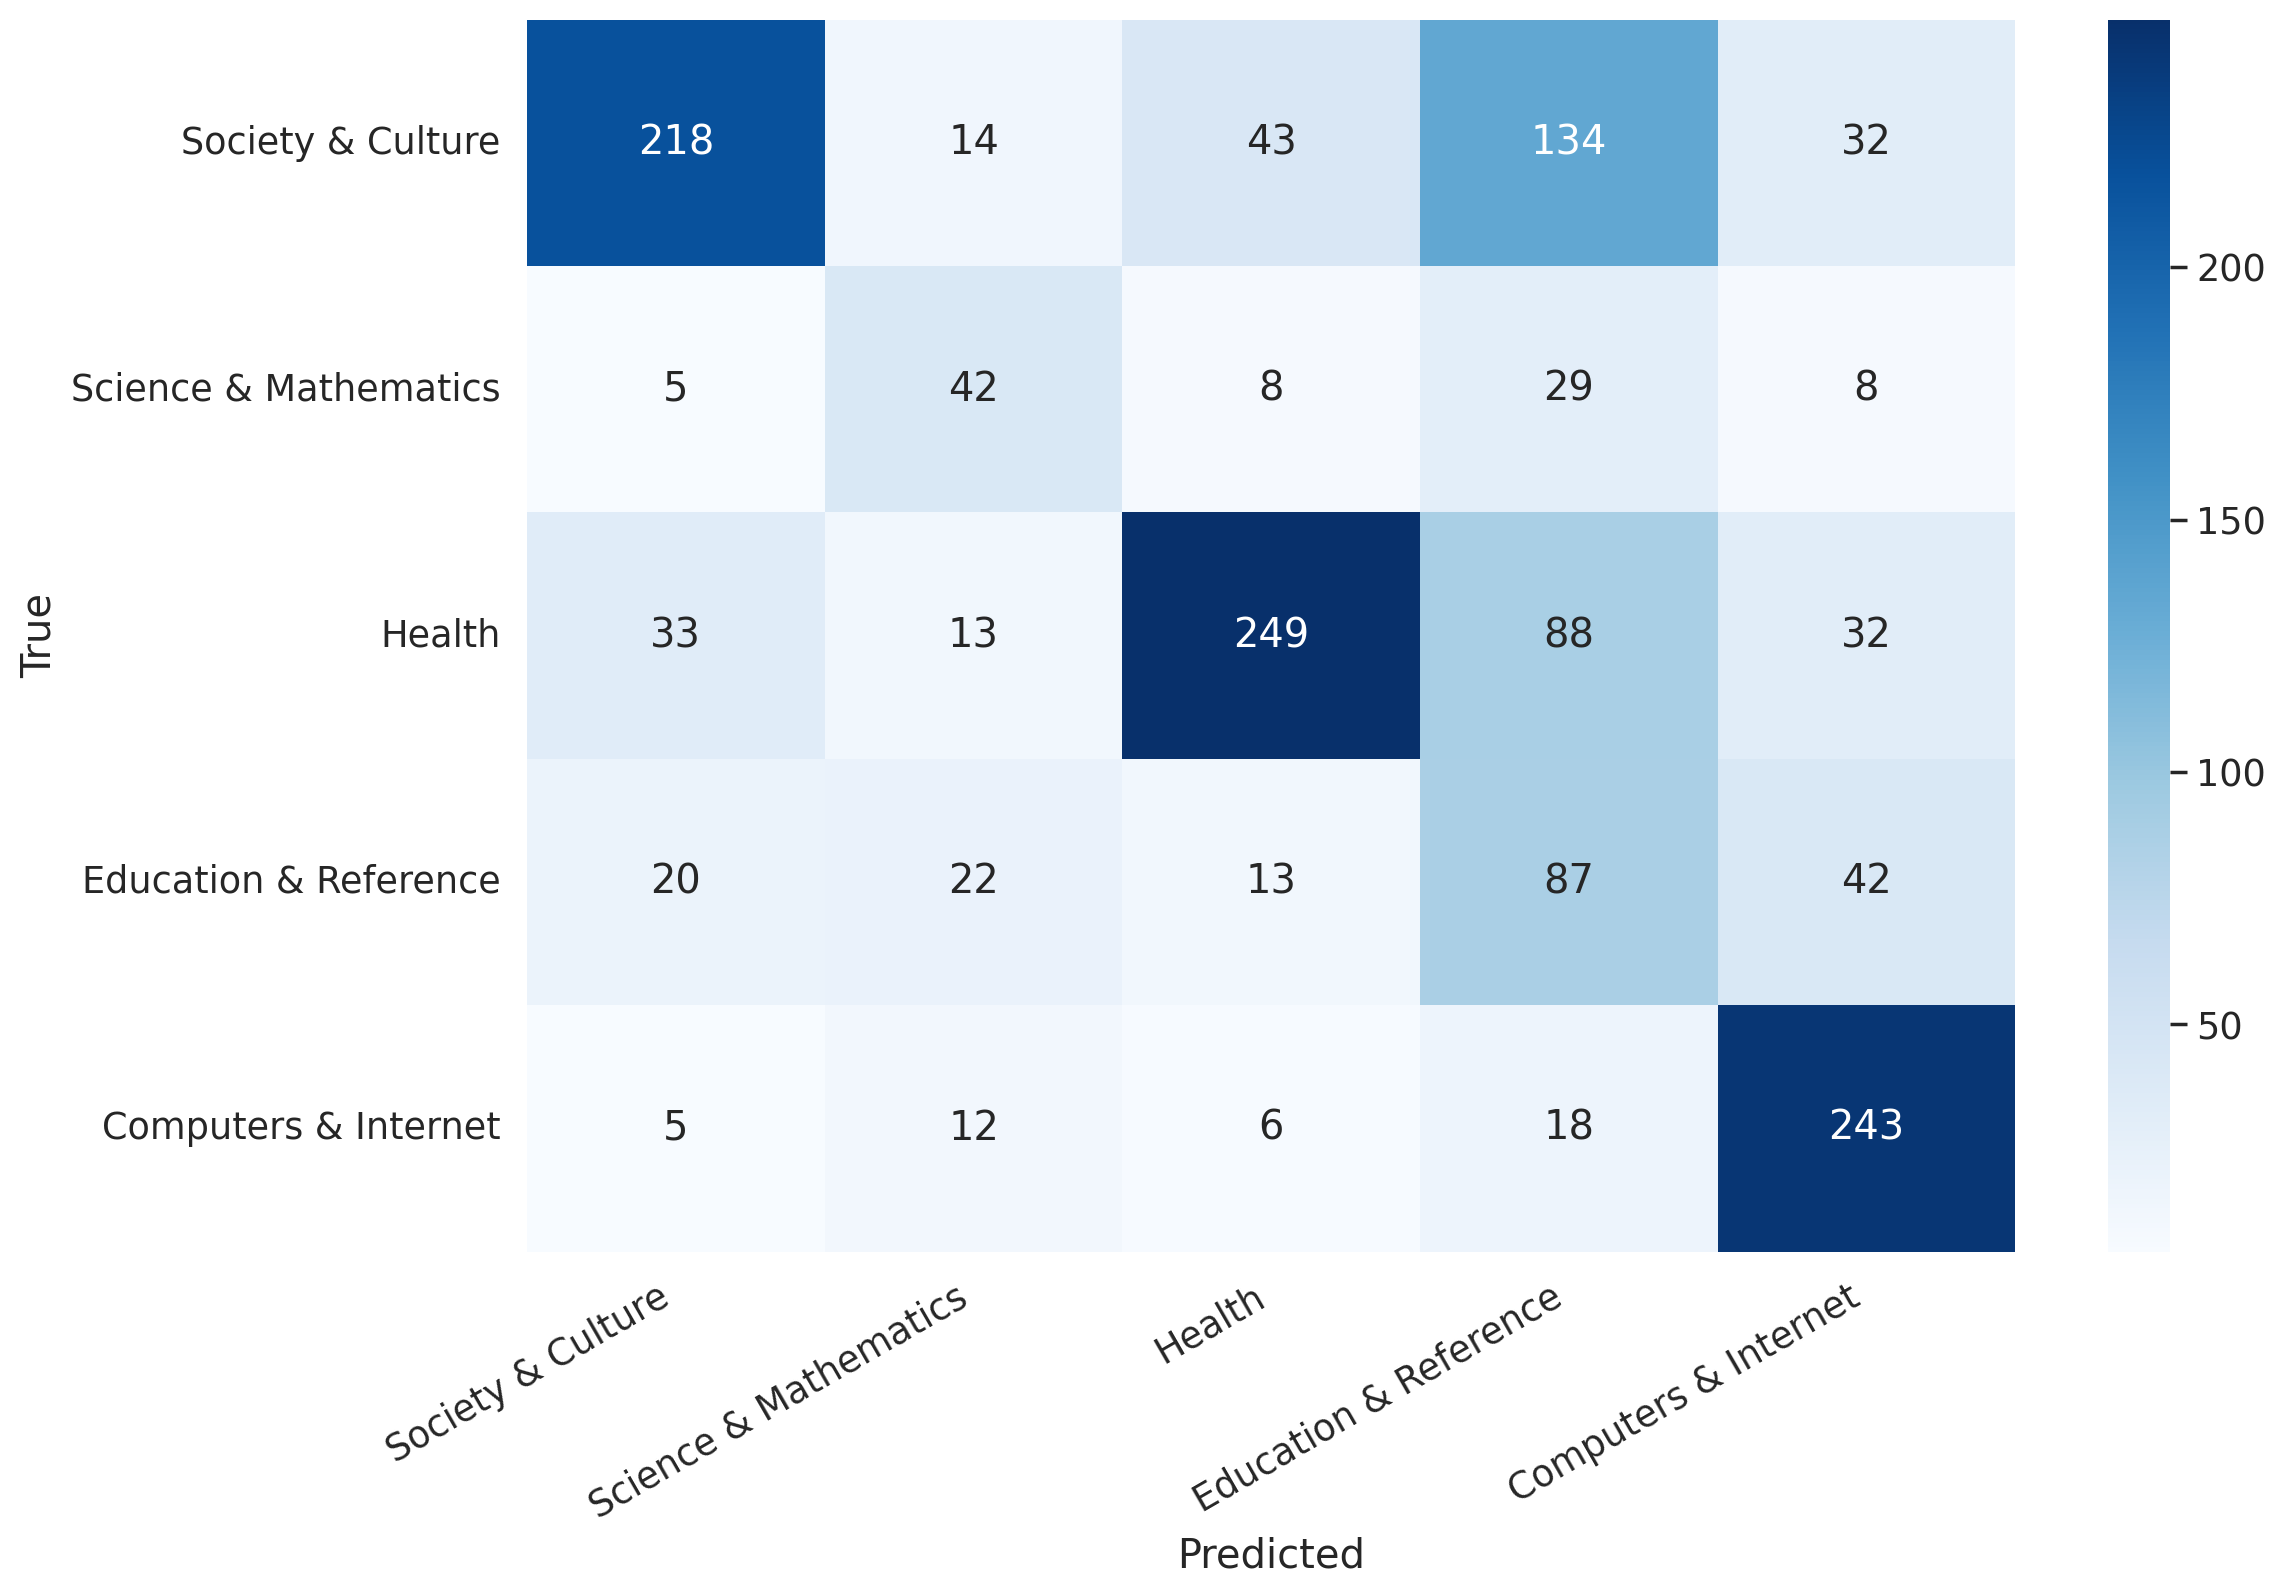

In [49]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True')
  plt.xlabel('Predicted');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=labels[0:5], columns=labels[0:5])
show_confusion_matrix(df_cm)

In [50]:
print(classification_report(y_test, y_pred, target_names=labels[0:5]))

                       precision    recall  f1-score   support

    Society & Culture       0.78      0.49      0.60       441
Science & Mathematics       0.41      0.46      0.43        92
               Health       0.78      0.60      0.68       415
Education & Reference       0.24      0.47      0.32       184
 Computers & Internet       0.68      0.86      0.76       284

             accuracy                           0.59      1416
            macro avg       0.58      0.58      0.56      1416
         weighted avg       0.67      0.59      0.61      1416

